In [1]:
import pickle
import pathlib
import collections
import community
import numpy as np
import pandas as pd
import networkx as nx

from scipy import spatial
from matplotlib import pyplot as plt

In [2]:
rel_data_folder_path = pathlib.Path("./../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network_graphs = rel_data_folder_path.joinpath('network_graphs')

- **d(integer)**: Straight-line distance between two stops expressed in meters.
- **duration_avg(integer)**: Travel time between stops averaged over all PT vehicles rounded to one second accuracy.
- **n_vehicles(integer)**: Number of PT vehicles that have traveled between two stops within a time interval
- **route_I_counts(list (string))**: A list of route_I's and the number of times each route has operated between two stops. For the network extracts, this data is formatted as a string where each element is written as `route_I:count` and different routes are separated by a comma. An example value for this field is thus `1:3,2:131,10:93`. Please note that the definition of a route varies across the cities provided, and that routes can have deviations from their main paths for instance when traveling to and from a depot.
- **route_I(integer)**: Identifier for a route.

Below is a table extracted from the [Data Paper](https://www.nature.com/articles/sdata201889) about the types of routes.

<img src="./../../data/images/about_transport_data/route-types.png" alt="Route Types" width="60%" title="route-types">

In [3]:
city_name = "venice"
with open(city_network_graphs.joinpath(city_name + '.gpickle'), 'rb') as f:
    city_network = pickle.load(f)

In [4]:
num_nodes = city_network.number_of_nodes()
num_edges = city_network.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 1874
Number of edges: 2737


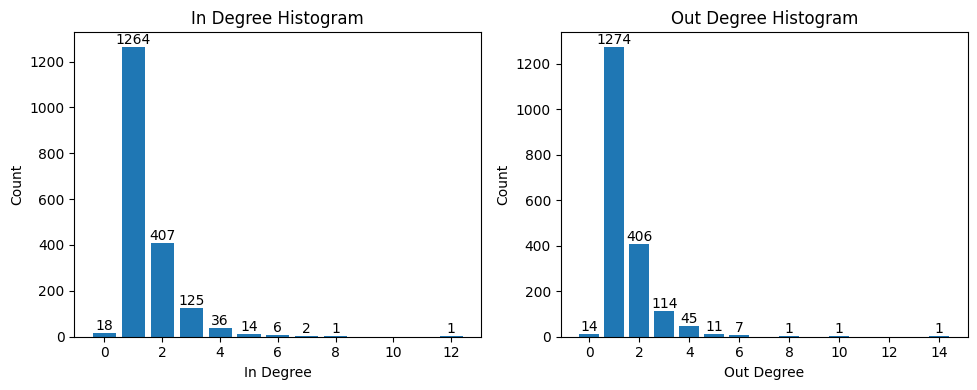

In [5]:
# node degree histogram.

in_degree_sequence = sorted([d for n, d in city_network.in_degree()], reverse=True)
in_degreeCount = collections.Counter(in_degree_sequence)
in_deg, in_count = zip(*in_degreeCount.items())


out_degree_sequence = sorted([d for n, d in city_network.out_degree()], reverse=True)
out_degreeCount = collections.Counter(out_degree_sequence)
out_deg, out_count = zip(*out_degreeCount.items())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
inbars = axes[0].bar(in_deg, in_count)
axes[0].set_title("In Degree Histogram")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("In Degree")
axes[0].bar_label(inbars)

outbars = axes[1].bar(out_deg, out_count)
axes[1].set_title("Out Degree Histogram")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Out Degree")
axes[1].bar_label(outbars)

fig.tight_layout()

In [ ]:
# Calculate the in-degree of each node, which represents the number of incoming edges
in_degree = city_network.in_degree()

# Sort the stops by the number of incoming edges in descending order
busiest_stops = sorted(in_degree, key=lambda x: x[1], reverse=True)

# Visualize the busiest stops on a map
fig, ax = plt.subplots()
for node in city_network.nodes(data=True):
    if node[0] == busiest_stops[0][0]:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='red', s=20, label='Busiest stop')
    else:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='blue', s=5)

ax.legend()
plt.show()

In [ ]:
# Create a dataframe with the stop and number of vehicles that have traveled through it
# stop_counts = pd.DataFrame([(n, G.in_degree(n, weight='vehicle_count')) for n in G.nodes()], 
#                            columns=['stop_id', 'vehicle_count'])

# # Sort the dataframe by vehicle count and select the top 10 stops
# top_stops = stop_counts.sort_values('vehicle_count', ascending=False).head(10)

# # Plot the top stops on a map
# fig = plt.figure(figsize=(8,8))
# m = Basemap(projection='merc', resolution='h', 
#             llcrnrlat=40, urcrnrlat=60,
#             llcrnrlon=10, urcrnrlon=30)

# m.drawcoastlines()
# m.fillcontinents(color='gray')
# m.drawcountries()
# m.drawmapboundary()

# for index, row in top_stops.iterrows():
#     x, y = m(row['longitude'], row['latitude'])
#     m.plot(x, y, 'ro', markersize=row['vehicle_count'], alpha=0.5)

# plt.show()

In [ ]:
# Group the edges by route type and calculate the average travel time for each group
route_types = edge_df['route_type'].unique()
for route_type in route_types:
    edges = [edge for edge in G.edges(data=True) if edge[2]['route_type'] == route_type]
    average_travel_time = sum([edge[2]['weight'] for edge in edges]) / len(edges)
    print(f"Average travel time for route type {route_type}: {average_travel_time}")

In [ ]:
# Calculate the in-degree of each node, which represents the number of incoming edges
in_degree = city_network.in_degree()

# Sort the stops by the number of incoming edges in descending order
busiest_stops = sorted(in_degree, key=lambda x: x[1], reverse=True)

# Visualize the transport network on a map
fig, ax = plt.subplots()

for edge in city_network.edges(data=True):
    for node in city_network.nodes(data=True):
        if node[0] == edge[0]:
            source = node
        elif node[0] == edge[1]:
            target = node
            
    weight = edge[2]['duration_avg']
    ax.plot([source[1]['lon'], target[1]['lon']],
            [source[1]['lat'], target[1]['lat']],
            c='gray', alpha=min(weight/500, 1))

for node in city_network.nodes(data=True):
    if node[0] == busiest_stops[0][0]:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='red', s=20, label='Busiest stop')
    else:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='blue', s=5)    

ax.legend()    
plt.show()

In [ ]:
# Calculate the betweenness centrality of each node
betweenness = nx.betweenness_centrality(city_network, weight='duration_avg')

# Visualize the betweenness centrality of nodes
pos = nx.spring_layout(city_network)
node_sizes = [betweenness[n] * 100 for n in city_network.nodes()]
nx.draw_networkx_nodes(city_network, pos, node_size=node_sizes, node_color='blue', alpha=0.5)
nx.draw_networkx_edges(city_network, pos, edge_color='gray', alpha=0.5)
# nx.draw_networkx_labels(city_network, pos, labels=nx.get_node_attributes(city_network, 'name'), font_size=8)
plt.axis('off')
plt.show()

In [ ]:
print("Network sparsity: %.4f" %nx.density(city_network))

In [ ]:
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(city_network, betweenness, 'betweenness')

# similar pattern
list_nodes =list(city_network.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(city_network)
ec = nx.draw_networkx_edges(city_network, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(city_network, pos, node_size=200, nodelist=list_nodes, node_color=[city_network.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()